# notMNIST classification using multinomial logistic regression

Firstly, import the data. All the images were preprocessed and saved into a ndarray object
and stored in a pickle file as a dictionary containing {test_dataset, test_labels, train_dataset, train_labels}

In [180]:
import numpy as np
import os
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import print_function

In [181]:
file = pickle.load(open('notMNIST.pickle', 'rb'))
print(file.keys())

dict_keys(['valid_labels', 'train_dataset', 'train_labels', 'test_labels', 'valid_dataset', 'test_dataset'])


In [182]:
training_X = file['train_dataset']
training_Y = file['train_labels']

testing_X = file['test_dataset']
testing_Y = file['test_labels']

print('Training size', len(training_X))
print('Testing size', len(testing_X))

# the labels are stored as int values [0-9] for classes [A-J]
def get_label(i):
    return 'ABCDEFGHI'[i]

Training size 200000
Testing size 10000


Lets see what the dataset looks like. Each image was normalized before storing in order to reduce overfitting.

Label for the example show below is B


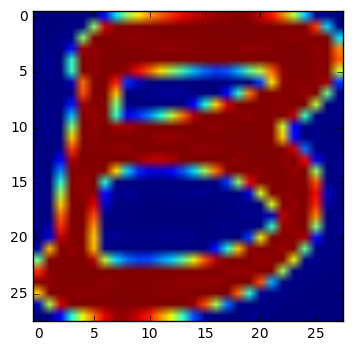

In [184]:
from random import randint
random_index = randint(0, 200000)
example = training_X[random_index]
print('Label for the example show below is', get_label(training_Y[random_index]))
plt.imshow(example)

For the sake of learning and save time, I will select a small subset of data for training and testing purpose.

In [185]:
training_X = training_X[0:10000]
training_Y = training_Y[0:10000]

testing_X = testing_X[0:1000]
testing_Y = testing_Y[0:1000]

print('Training size', len(training_X))
print('Testing size', len(testing_X))

Training size 10000
Testing size 1000


Multinomial logistic classification: Take the examples (X) and convert them into logits using WX + b. Then convert the output variables into probability ditribution using softmax. Compare the probability distribution with the one-hot encoding using cross entropy cost function. Here is the simplied formula

In [186]:
from IPython.display import Math
print('Logistic regression formula')
Math(r'F = \frac{1}{N}\sum_{i=1}^{N}H(\sigma (Wx{i}+b), L_{i})',)

Logistic regression formula


<IPython.core.display.Math object>

In [187]:
print('Sigmoid Function')
Math(r'\sigma = \frac{e^{z_{j}}}{\sum_{k=1}^{N} e^{z_{k}}}')

Sigmoid Function


<IPython.core.display.Math object>

In [188]:
print('Cross Entropy Function. S is the softmax probability and L is the one-hot encoding')
Math(r'H(S, L) = - \sum_{i=1}^{N} L_i * log(S_i)')

Cross Entropy Function. S is the softmax probability and L is the one-hot encoding


<IPython.core.display.Math object>

We need to flatten our tensor which is (N, (28,28)) into (N, 28*28) for the classifier to train

In [189]:
# flatten the tensor from [N, (x,y)] to [N, x*y] so we can input into our classifier
N,x,y = training_X.shape
train_X = np.reshape(training_X, (N, x*y))
N,x,y = testing_X.shape
test_X = np.reshape(testing_X, (N, x*y))

print('Training size', (train_X).shape)
print('Testing size', (test_X).shape)

Training size (10000, 784)
Testing size (1000, 784)


Using scikit learn library.

In [190]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(train_X, training_Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [191]:
training_acc = classifier.score(train_X, training_Y)
testing_acc = classifier.score(test_X, testing_Y)
print('Training Accuracy', training_acc*100)
print('Testing Accuracy', testing_acc*100)

Training Accuracy 90.62
Testing Accuracy 88.0


Implementing using tensorflow

In [194]:
# TODO implement the multinomial logistic regression using tensorflow
x = tf.placeholder(tf.float32, [None, 784]) # 784 is input size because image size is (28*28) and we flatten it 
W = tf.Variable(tf.zeros([784, 10])) # input 784 output is 10
b = tf.Variable(tf.zeros([10]))
y_predicted = tf.add(tf.matmul(x, W),b) #predicted labels (prob-dist)
y_actual = tf.placeholder(tf.float32, [None, 10]) #actual labels

# cross entropy cost function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=y_predicted, labels=y_actual)
cost = tf.reduce_mean(cross_entropy)

# gradient descent optmizer (backstep)
optimizer = tf.train.GradientDescentOptimizer(0.001).minimize(cost)

# initializer the variables
init = tf.global_variables_initializer()

We need to transform the output label into one hot encoding to input into our tensorflow

In [195]:
def one_hot_encoding(X):
    encoding = np.zeros([len(X), 10])
    encoding[np.arange(len(X)), X] = 1
    return encoding

training_encodedY = one_hot_encoding(training_Y)
testing_encodedY = one_hot_encoding(testing_Y)

In [209]:
sess = tf.Session()
sess.run(init)
cost_list = []
training_acc_list = []
testing_acc_list = []
for i in range(1000):
    avg_cost = 0.0
    train_acc = 0.0
    test_acc = 0.0
    _, c = (sess.run([optimizer, cost], feed_dict={x:train_X, y_actual:training_encodedY}))
    avg_cost += c
    cost_list.append(c)
    correct_prediction = tf.equal(tf.argmax(y_predicted,1), tf.argmax(y_actual, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    train_acc = sess.run(accuracy, feed_dict={x:train_X, y_actual:training_encodedY})
    test_acc = sess.run(accuracy, feed_dict={x:test_X, y_actual:testing_encodedY})
    training_acc_list.append(train_acc)
    testing_acc_list.append(test_acc)
    if i%100 == 0: 
        print('Epoch:', i, 'Cost', avg_cost, 'Training accuracy', train_acc, 'Testing accuracy', test_acc)
print('Finished')

Epoch: 0 Cost 2.30260133743 Training accuracy 0.6774 Testing accuracy 0.746
Epoch: 100 Cost 2.05056595802 Training accuracy 0.6944 Testing accuracy 0.758
Epoch: 200 Cost 1.8537312746 Training accuracy 0.7098 Testing accuracy 0.772
Epoch: 300 Cost 1.69824373722 Training accuracy 0.7232 Testing accuracy 0.78
Epoch: 400 Cost 1.57406044006 Training accuracy 0.7351 Testing accuracy 0.794
Epoch: 500 Cost 1.47367310524 Training accuracy 0.7453 Testing accuracy 0.803
Epoch: 600 Cost 1.39147269726 Training accuracy 0.7519 Testing accuracy 0.813
Epoch: 700 Cost 1.32329332829 Training accuracy 0.7571 Testing accuracy 0.82
Epoch: 800 Cost 1.26604545116 Training accuracy 0.7626 Testing accuracy 0.824
Epoch: 900 Cost 1.21742892265 Training accuracy 0.767 Testing accuracy 0.828
Finished


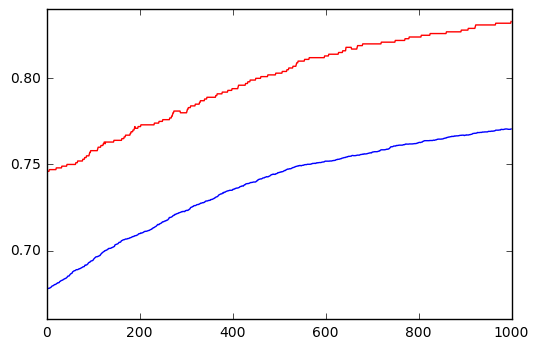

In [234]:
epochs = range(1000)
plt.plot(epochs, training_acc_list,'b', testing_acc_list, 'r')

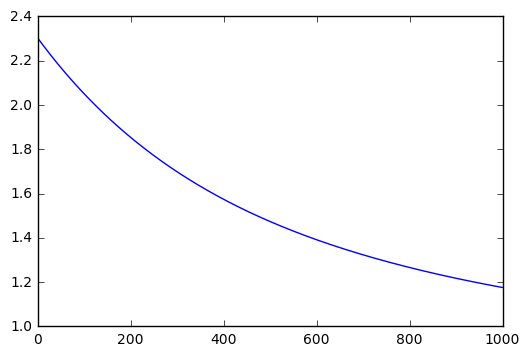

In [235]:
plt.plot(epochs, cost_list)